In [1]:
import pandas as pd
from sklearn.preprocessing import normalize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data=pd.read_csv("data_subject/data_subject_filtrage_5.csv")

In [3]:
df=data.dropna()

In [4]:
df

,index,nb_seance,nb_passage,x_lumbar,y_lumbar,z_lumbar,x_tibia,y_tibia,z_tibia,x_force,y_force,z_force
0,0,0.0,0.0,-0.584479,-0.345383,-0.052900,-0.172684,-0.633431,-0.539423,3.558498,18.286360,31.815727
1,1,0.0,0.0,-0.583906,-0.345048,-0.052368,-0.170232,-0.633053,-0.539136,3.730948,18.572290,32.158100
2,2,0.0,0.0,-0.583333,-0.344718,-0.051836,-0.167770,-0.632681,-0.538853,3.877251,18.870435,32.547327
3,3,0.0,0.0,-0.582759,-0.344391,-0.051302,-0.165297,-0.632316,-0.538577,3.998568,19.180298,32.981525
4,4,0.0,0.0,-0.582186,-0.344068,-0.050768,-0.162814,-0.631960,-0.538308,4.096060,19.501382,33.458811
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,4995,9.0,9.0,-0.205340,0.681640,-0.425896,-0.293048,0.391366,1.324989,-0.369692,-9.566315,26.754350
499996,4996,9.0,9.0,-0.206102,0.681626,-0.425648,-0.294966,0.390823,1.325162,-0.333361,-9.505878,26.596084
499997,4997,9.0,9.0,-0.206869,0.681610,-0.425398,-0.296887,0.390285,1.325333,-0.290113,-9.447726,26.438087
499998,4998,9.0,9.0,-0.207639,0.681594,-0.425148,-0.298809,0.389751,1.325500,-0.239586,-9.392121,26.280158


/home/rmarrion/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='z_force'>

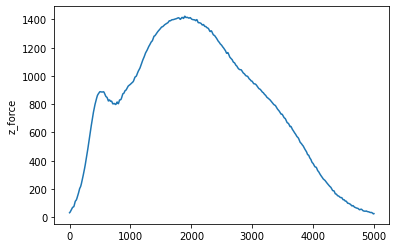

In [5]:
sns.lineplot(df.index[:5000],df['z_force'].iloc[:5000])

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X=df.drop(['index','nb_seance','nb_passage','x_force','z_force','y_force'],axis=1)
#X=df.drop(['index','nb_seance','nb_passage','x_lumbar','y_lumbar','z_lumbar','x_force','z_force','y_force'],axis=1)
y=df['z_force']

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [9]:
from sklearn.ensemble import RandomForestRegressor

rfr=RandomForestRegressor()
rfr.fit(X_train,y_train)

rfr.score(X_test,y_test)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

cross_val_score(rfr,X,y,cv=5).mean()

In [11]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X_poly,y,random_state=42,test_size=0.2)
lr = LinearRegression()
cross_val_score(lr,X_poly,y,cv=5).mean()

0.7389781741581549

In [12]:

X_train_tho=X_poly[:-5000,:]
y_train_tho=y[:-5000]
X_test_tho=X_poly[445000:,:]
y_test_tho=y[445000:]
lr_tho = LinearRegression()
lr_tho.fit(X_train_tho, y_train_tho)
y_pred_tho=lr_tho.predict(X_test_tho)

In [13]:
lr_tho.score(X_test_tho,y_test_tho)

0.5968071891914323

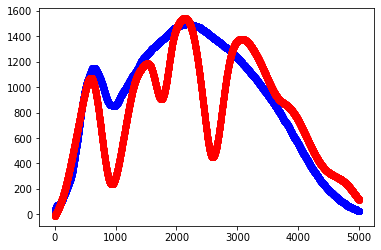

In [14]:
x=range(0,5000)
plt.scatter(x,y_test_tho,color='b')
plt.scatter(x,y_pred_tho,color='r')

In [15]:
from sklearn.metrics import mean_squared_error

In [16]:
def exceptOneValidation(model,X,y,period=5000):
    score=[]
    predict=[]
    error=[]
    for i in range(0,len(X),period):
        if i==0:
            X_train=X.iloc[period:,:]
            y_train=y.iloc[period:]
            X_test=X.iloc[0:period,:]
            y_test=y.iloc[0:period]
        elif i==len(X)-period:
            X_train=X.iloc[0:i,:]
            y_train=y.iloc[0:i]
            X_test=X.iloc[i:i+period,:]
            y_test=y.iloc[i:i+period]
        else:
            X_train=pd.concat([X.iloc[0:i,:],X.iloc[i+period:,:]],axis=0)
            y_train=pd.concat([y.iloc[0:i],y.iloc[i+period:]],axis=0)
            X_test=X.iloc[i:i+period,:]
            y_test=y.iloc[i:i+period]
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        predict=np.concatenate([predict,y_pred])
        score.append(model.score(X_test,y_test))
        error.append(mean_squared_error(y_test,y_pred))
    return score,error,predict

# Polynomial regression

In [17]:
poly = PolynomialFeatures(degree = 3)
X_poly = pd.DataFrame(poly.fit_transform(X))
model=LinearRegression()
score_pr,error_pr,predict_pr=exceptOneValidation(model,X_poly,y,period=5000)

In [18]:
pd.Series(score_pr).describe()

count    90.000000
mean      0.893655
std       0.079392
min       0.574486
25%       0.877694
50%       0.915632
75%       0.938808
max       0.975054
dtype: float64

In [23]:
pd.Series(error_pr).describe()

count       90.000000
mean     24859.633526
std      17972.456135
min       6208.663680
25%      13952.377881
50%      18941.334896
75%      26314.518675
max      89117.321335
dtype: float64

/tmp/ipykernel_46270/2199150661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predict']=np.vstack(predict_pr)


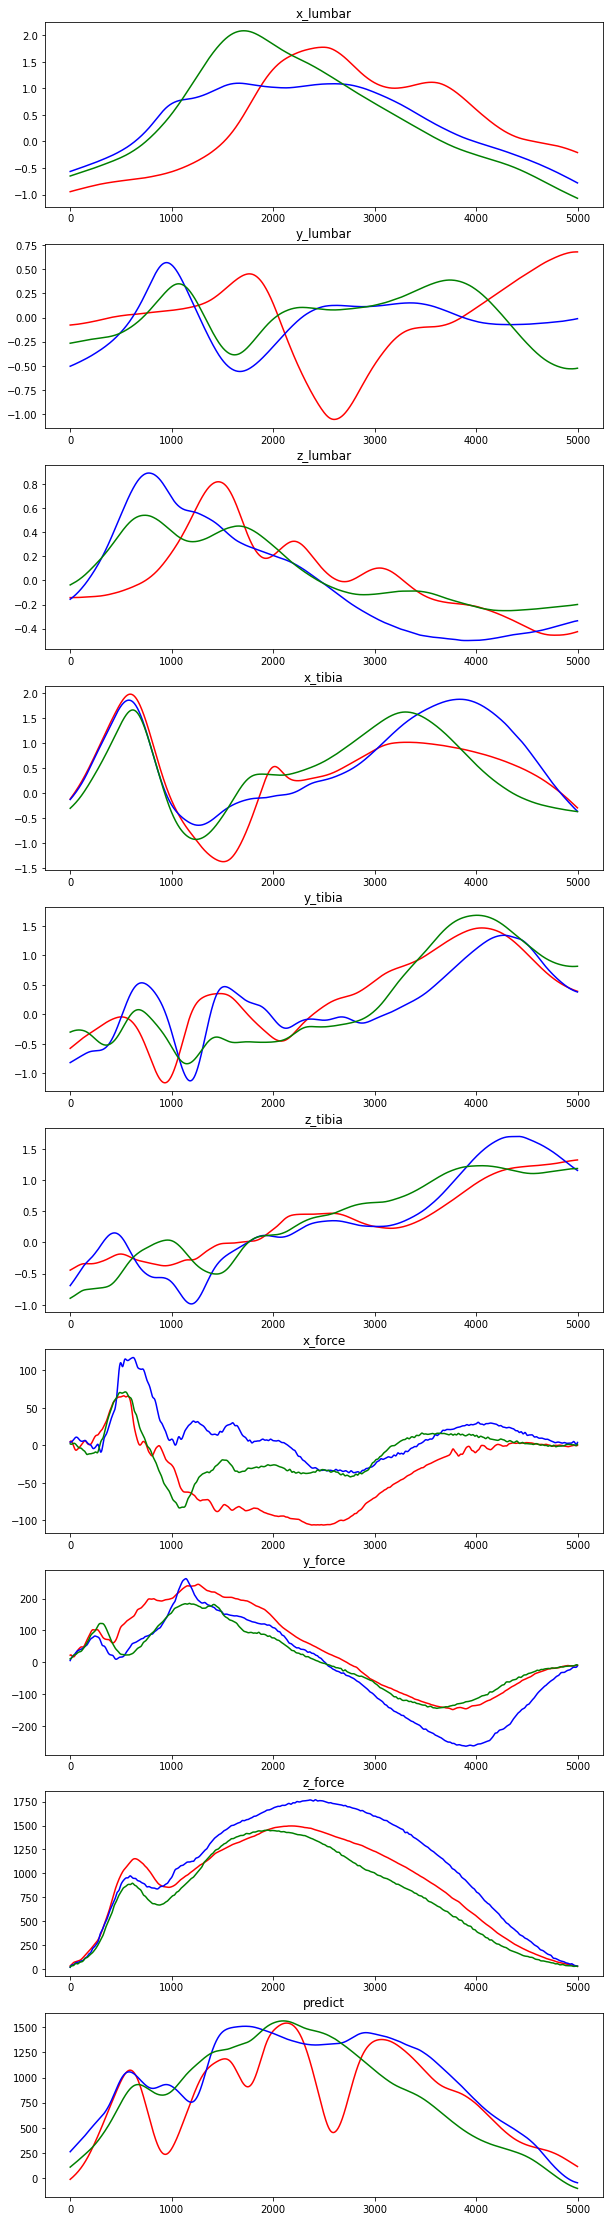

In [19]:
k=89
n=10
i=1
df['predict']=np.vstack(predict_pr)
fig,axes = plt.subplots(10,1,figsize=(10,40))
for row,col in enumerate(df.columns[3:]):
    df[col].iloc[k*5000:k*5000+5000].reset_index(drop=True).plot(ax=axes[row],title=col,color='r')
    df[col].iloc[n*5000:n*5000+5000].reset_index(drop=True).plot(ax=axes[row],color='b')
    df[col].iloc[i*5000:i*5000+5000].reset_index(drop=True).plot(ax=axes[row],color='g')


# Decision Tree

In [24]:
from sklearn.tree import DecisionTreeRegressor
model=DecisionTreeRegressor()
score,error,predict=exceptOneValidation(model,X,y,period=5000)

In [25]:
pd.Series(score).describe()

count    90.000000
mean      0.927365
std       0.051541
min       0.736340
25%       0.902489
50%       0.946125
75%       0.964568
max       0.991712
dtype: float64

In [26]:
pd.Series(error).describe()

count       90.000000
mean     17149.113133
std      13067.523405
min       1487.161653
25%       8019.501310
50%      12855.655756
75%      21739.683761
max      71874.106439
dtype: float64